In [2]:
!pip install tensorflow-addons


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install tqdm


  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/2a/14/e75e52d521442e2fcc9f1df3c5e456aead034203d4797867980de558ab34/tqdm-4.66.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 640.0 kB/s eta 0:00:01
     --------------------------- ---------- 41.0/57.6 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 335.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   --------------- ------------------------ 30.7/78.3 kB 1.4 MB/s eta 0:00:01
   ------------------------------- -------- 61.4/78.3 kB 656.4 kB/s eta 0:00:01
   ------------------------------- -------- 61.4/78.3 kB 656.4 kB/s eta 0:00:01
   ---------------------------------------- 78.3/78.3 kB 436.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [18]:
# Resizing all the images to 64*64 pixels and storing in compressed Numpy array.
import os
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_images(path, size=(64, 64), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(os.path.join(path, filename), target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

celeb_path = r'C:\Users\Anushka\Downloads\archive\img_align_celeba\img_align_celeba'
cartoon_path = r'C:\Users\Anushka\Downloads\Cartoon\cartoonset10k'

dataA = load_images(celeb_path, max_images=1000)
print('loaded dataA', dataA.shape)

dataB = load_images(cartoon_path, max_images=1000)
print('loaded dataB', dataB.shape)

filename = 'celebrity2cartoon.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)

print('Saved dataset:', filename)


loaded dataA (1000, 64, 64, 3)
loaded dataB (1000, 64, 64, 3)
Saved dataset: celebrity2cartoon.npz


Loaded data: (1000, 64, 64, 3) (1000, 64, 64, 3)


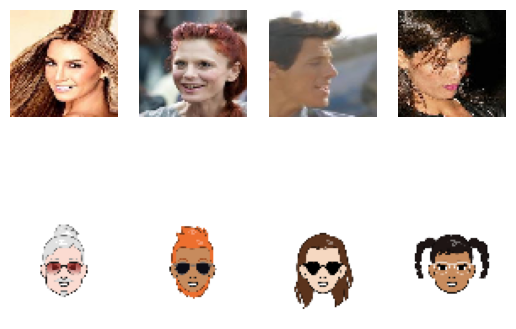

In [20]:
from numpy import load
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot module
data = load('celebrity2cartoon.npz')
dataA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)
n_samples = 4
# plot original image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()


In [4]:
pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\anushka\appdata\local\temp\pip-req-build-06fipx6c
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101677 sha256=eec6b328ddb544fa18c0d7bfd8d3b8b29f98039d076bab2abeefa33e6288afef
  Stored in directory: C:\Users\Anushka\AppData\Local\Temp\pip-ephem-wheel-cache-5ciw5omh\wheels\83\b3\99\125cd08d3e8224b434b1b4badd6f8b2651e0251b7e8f983e60
Successfully built keras-contrib
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git 'C:\Users\Anushka\AppData\Local\Temp\pip-req-build-06fipx6c'


In [8]:
!pip install keras

In [10]:
from numpy.random import randint
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, Activation, Concatenate
from keras.layers import Layer, BatchNormalization
import keras.backend as K

class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:],
                                     initializer=RandomNormal(mean=1.0, stddev=0.02), trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:],
                                      initializer='zeros', trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, x):
        mean, variance = K.mean(x, axis=[1, 2], keepdims=True), K.var(x, axis=[1, 2], keepdims=True)
        return self.scale * (x - mean) / K.sqrt(variance + self.epsilon) + self.offset

    def compute_output_shape(self, input_shape):
        return input_shape

# Define the discriminator model
def define_discriminator(image_shape):
    # Weight initialization
    init = RandomNormal(stddev=0.02)
    # Source image input
    input_image = Input(shape=image_shape)
    # C64
    x = Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=init)(input_image)
    x = LeakyReLU(alpha=0.2)(x)
    # C128
    x = Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization()(x)  # Using the custom InstanceNormalization layer
    x = LeakyReLU(alpha=0.2)(x)
    # C256
    x = Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization()(x)  # Using the custom InstanceNormalization layer
    x = LeakyReLU(alpha=0.2)(x)
    # C512
    x = Conv2D(512, (4, 4), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization()(x)  # Using the custom InstanceNormalization layer
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization()(x)  # Using the custom InstanceNormalization layer
    x = LeakyReLU(alpha=0.2)(x)

    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

    return model

image_shape = (64, 64, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 instance_normalization (In  (None, 16, 16, 128)       256       
 stanceNormalization)                                            
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                             

In [12]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    #print(layer.shape)  # print the shape of the previous layer
    
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    
    # skip connection
    x = Concatenate()([x, layer])
    return x

In [13]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding ='same', kernel_initializer='he_normal', use_bias=False)(layer)
    x = InstanceNormalization(axis=-1)(x)    
    x = LeakyReLU()(x)
    return x

In [4]:
from keras.initializers import RandomNormal
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, Concatenate, BatchNormalization
from keras.models import Model
import tensorflow as tf  # Import TensorFlow to access the Concatenate layer

def resnet_block(n_filters, input_layer):
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(input_layer)
    g = BatchNormalization()(g)  # Use BatchNormalization instead of InstanceNormalization
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(g)
    g = BatchNormalization()(g)  # Use BatchNormalization instead of InstanceNormalization
    # concatenate merge channel-wise with input layer
    g = tf.keras.layers.Concatenate()([g, input_layer])
    return g

def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    input_image = Input(shape=image_shape)
    # c64
    x = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(input_image)
    x = BatchNormalization()(x)  # Use BatchNormalization instead of InstanceNormalization
    x = Activation('relu')(x)
    # c128
    x = Conv2D(128, (3,3), strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)  # Use BatchNormalization instead of InstanceNormalization
    x = Activation('relu')(x)
    # c256
    x = Conv2D(256, (3,3), strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)  # Use BatchNormalization instead of InstanceNormalization
    x = Activation('relu')(x)
    
    # Add ResNet blocks
    for _ in range(n_resnet):
        x = resnet_block(256, x)
        
    # Add Conv2DTranspose layers to upscale the image to the desired shape
    x = Conv2DTranspose(128, (3,3), strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)  # Use BatchNormalization instead of InstanceNormalization
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3,3), strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)  # Use BatchNormalization instead of InstanceNormalization
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)  # Use BatchNormalization instead of InstanceNormalization
    out_image = Activation('tanh')(x)

    model = Model(input_image, out_image)
    return model

image_shape = (64, 64, 3)
generator = define_generator(image_shape)
generator.summary()


C:\Users\Anushka\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['batch_normalization[0][0

In [7]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Input for generated images
    input_gen = Input(shape=image_shape)
    
    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (64, 64), method=tf.image.ResizeMethod.BILINEAR))(input_gen)
    
    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)
    
    # Input for identity mapping
    input_id = Input(shape=image_shape)
    
    # Forward pass for identity mapping
    output_id = g_model_1(input_id)
    
    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)
    
    # Define the composite model
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    
    return model

In [8]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for corresponding target images
    return [X1,X2]

In [9]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [10]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))
    
    return X, y

In [11]:
#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))

In [13]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  # This line should be outside the for loop

In [14]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [15]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('celebrity2cartoon.npz')
        celeb, cartoon = dataA[id], dataB[id]
        celeb_pred, cartoon_pred = g_BA.predict(tf.expand_dims(cartoon, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Original celeb')
        
        plt.subplot(1, 4, 2)
        show_image(cartoon_pred, title='Generated celeb')
        
        plt.subplot(1, 4, 3)
        show_image(cartoon.astype('uint8'), title='Original cartoon')
        
        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Generated cartoon')
        
        
        plt.show()

In [17]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=10, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch 
    #manually enumerate epochs
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)
            
            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)




            
            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            
            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))

        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)
                #save the models
            g_model_AtoB.save('Generator_Celebrity_to_Cartoon.h5')
            g_model_BtoA.save('Generator_Cartoon_to_Celebrity.h5')

In [10]:
#load image data
dataset = load_real_samples ('celebrity2cartoon.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)
#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B,g_model_BtoA,image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A,g_model_AtoB,image_shape)
train(dataset,d_model_A,d_model_B, g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , epochs=10, chunk=5)

KeyError: 'arr_0 is not a file in the archive'